# Data Preprocessing

In [31]:
import pandas as pd
import re
import nltk
import itertools
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import time

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
#nltk.download('punkt_tab')
#nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [32]:
# Constants
TRAIN_DATA_NAME = 'sentiment140/sentiment140_training.csv'
TRAIN_COLUMN_NAMES = ['sentiment', 'tweets']

TEST_DATA_NAME = 'sentiment140/sentiment140_test.csv'
TEST_COLUMN_NAMES = ['sentiment', 'tweets']

ENCODING = 'latin-1'
NROWS = 1600000

pd.options.display.max_colwidth = None

In [33]:
# Load Datasets into Dataframe
train_df = pd.read_csv(
    TRAIN_DATA_NAME,
    encoding=ENCODING,
    header=0,
    names=TRAIN_COLUMN_NAMES,
    nrows=NROWS
    )

print('TRAIN DATASET: \n', train_df.head(4))


test_df = pd.read_csv(
    TEST_DATA_NAME,
    encoding=ENCODING,
    header=0,
    names=TEST_COLUMN_NAMES,
    nrows=NROWS
    )

print('\nTEST DATASET: \n', test_df.head(4))

TRAIN DATASET: 
    sentiment  \
0          0   
1          0   
2          0   
3          0   

                                                                                                                tweets  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!  
2                            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds  
3                                                                      my whole body feels itchy and like its on fire   

TEST DATASET: 
    sentiment  \
0          4   
1          4   
2          4   
3          4   

                                                                                                                                         tweets  
0                               @stellargirl I looooo

Unterschiedliche Versionen herstellen

In [34]:
stop_words = stopwords.words("english")
#sorted(stop_words, key=str.casefold)

negation_words = [
    'ain',
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
]

reduced_stop_words = [word for word in stop_words if word not in negation_words]
print(reduced_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [35]:
# DEFINITIONS

def clean_tweets(tweet, apostrophe):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs

    if apostrophe:
        tweet = re.sub(r'[^\w\s\']+', ' ', tweet)
    else:
        tweet = re.sub(r'[^\w\s]+', ' ', tweet)

    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet) # Shorten letters with more than 2 occurences

    return tweet.lower().strip()


tweet_tokenizer = TweetTokenizer()
def tokenize_tweets(tweet):
    #tweet = word_tokenize(tweet)
    tweet = tweet_tokenizer.tokenize(tweet)
    return tweet


def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in reduced_stop_words]
    return tweet


lemmatizer = WordNetLemmatizer()
def lemmatize_tweets(tweet):
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    return tweet


stemmer = PorterStemmer()
def stem_tweets(tweet):
    tweet = [stemmer.stem(word) for word in tweet]
    return tweet



In [36]:
train_df["cleaned_w_apostrophe"] = train_df.tweets.apply(clean_tweets, apostrophe=True)
train_df["cleaned_w_apostrophe_t"] = train_df.cleaned_w_apostrophe.apply(lambda tweet: tokenize_tweets(tweet))
train_df["cleaned_w_apostrophe_t_w_r"] = train_df.cleaned_w_apostrophe_t.apply(lambda tweet: remove_stopwords(tweet))
train_df["cleaned_w_apostrophe_t_w_r_lem"] = train_df.cleaned_w_apostrophe_t_w_r.apply(lambda tweet: lemmatize_tweets(tweet))

train_df["cleaned_w_apostrophe_w_r_t"] = train_df.cleaned_w_apostrophe.apply(lambda tweet: tokenize_tweets(' '.join(remove_stopwords(tweet.split()))))
train_df["cleaned_w_apostrophe_w_r_t_lem"] = train_df.cleaned_w_apostrophe_w_r_t.apply(lambda tweet: lemmatize_tweets(tweet))
train_df["cleaned_w_apostrophe_t_wo_r"] = train_df.cleaned_w_apostrophe.apply(lambda tweet: tokenize_tweets(tweet))
train_df["cleaned_w_apostrophe_t_wo_r_lem"] = train_df.cleaned_w_apostrophe_t_wo_r.apply(lambda tweet: lemmatize_tweets(tweet))

train_df["cleaned_wo_apostrophe"] = train_df.tweets.apply(clean_tweets, apostrophe=False)
train_df["cleaned_wo_apostrophe_t"] = train_df.cleaned_wo_apostrophe.apply(lambda tweet: tokenize_tweets(tweet))
train_df["cleaned_wo_apostrophe_t_w_r"] = train_df.cleaned_wo_apostrophe_t.apply(lambda tweet: remove_stopwords(tweet))
train_df["cleaned_wo_apostrophe_t_w_r_lem"] = train_df.cleaned_wo_apostrophe_t_w_r.apply(lambda tweet: lemmatize_tweets(tweet))

train_df["cleaned_wo_apostrophe_w_r_t"] = train_df.cleaned_wo_apostrophe.apply(lambda tweet: tokenize_tweets(' '.join(remove_stopwords(tweet.split()))))
train_df["cleaned_wo_apostrophe_w_r_t_lem"] = train_df.cleaned_wo_apostrophe_w_r_t.apply(lambda tweet: lemmatize_tweets(tweet))
train_df["cleaned_wo_apostrophe_t_wo_r"] = train_df.cleaned_wo_apostrophe.apply(lambda tweet: tokenize_tweets(tweet))
train_df["cleaned_wo_apostrophe_t_wo_r_lem"] = train_df.cleaned_wo_apostrophe_t_wo_r.apply(lambda tweet: lemmatize_tweets(tweet))



print(train_df.iloc[0])
print('\n')
print(train_df.iloc[1])


sentiment                                                                                                                                             0
tweets                              @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
cleaned_w_apostrophe                                                          aww  that's a bummer  you shoulda got david carr of third day to do it  d
cleaned_w_apostrophe_t                                          [aww, that's, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]
cleaned_w_apostrophe_t_w_r                                                                 [aww, that's, bummer, shoulda, got, david, carr, third, day]
cleaned_w_apostrophe_t_w_r_lem                                                             [aww, that's, bummer, shoulda, got, david, carr, third, day]
cleaned_w_apostrophe_w_r_t                                                              

In [37]:
train_df["cleaned_w_apostrophe_t_w_r_stem"] = train_df.cleaned_w_apostrophe_t_w_r.apply(lambda tweet: stem_tweets(tweet))
train_df["cleaned_w_apostrophe_w_r_t_stem"] = train_df.cleaned_w_apostrophe_w_r_t.apply(lambda tweet: stem_tweets(tweet))
train_df["cleaned_w_apostrophe_t_wo_r_stem"] = train_df.cleaned_w_apostrophe_t_wo_r.apply(lambda tweet: stem_tweets(tweet))

train_df["cleaned_wo_apostrophe_t_w_r_stem"] = train_df.cleaned_wo_apostrophe_t_w_r.apply(lambda tweet: stem_tweets(tweet))
train_df["cleaned_wo_apostrophe_w_r_t_stem"] = train_df.cleaned_wo_apostrophe_w_r_t.apply(lambda tweet: stem_tweets(tweet))
train_df["cleaned_wo_apostrophe_t_wo_r_stem"] = train_df.cleaned_wo_apostrophe_t_wo_r.apply(lambda tweet: stem_tweets(tweet))

print(train_df.iloc[0])

sentiment                                                                                                                                              0
tweets                               @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
cleaned_w_apostrophe                                                           aww  that's a bummer  you shoulda got david carr of third day to do it  d
cleaned_w_apostrophe_t                                           [aww, that's, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]
cleaned_w_apostrophe_t_w_r                                                                  [aww, that's, bummer, shoulda, got, david, carr, third, day]
cleaned_w_apostrophe_t_w_r_lem                                                              [aww, that's, bummer, shoulda, got, david, carr, third, day]
cleaned_w_apostrophe_w_r_t                                                        

In [38]:

column_names = [
    [
        'cleaned_w_apostrophe_t_w_r_lem', 
        'cleaned_w_apostrophe_w_r_t_lem', 
        'cleaned_w_apostrophe_t_wo_r_lem', 
        'cleaned_wo_apostrophe_t_w_r_lem', 
        'cleaned_wo_apostrophe_w_r_t_lem', 
        'cleaned_wo_apostrophe_t_wo_r_lem'
    ],
    [
        'cleaned_w_apostrophe_t_w_r_stem', 
        'cleaned_w_apostrophe_w_r_t_stem', 
        'cleaned_w_apostrophe_t_wo_r_stem', 
        'cleaned_wo_apostrophe_t_w_r_stem', 
        'cleaned_wo_apostrophe_w_r_t_stem', 
        'cleaned_wo_apostrophe_t_wo_r_stem'
    ]
]


comparison_matrix = []
for normilization in column_names:
    for a, b in itertools.product(normilization, repeat=2):
        diff = train_df[a] == train_df[b]
        comparison_matrix.append(diff.sum()/NROWS)


value_matrix = np.reshape(comparison_matrix, (2,6,6))

<Axes: >

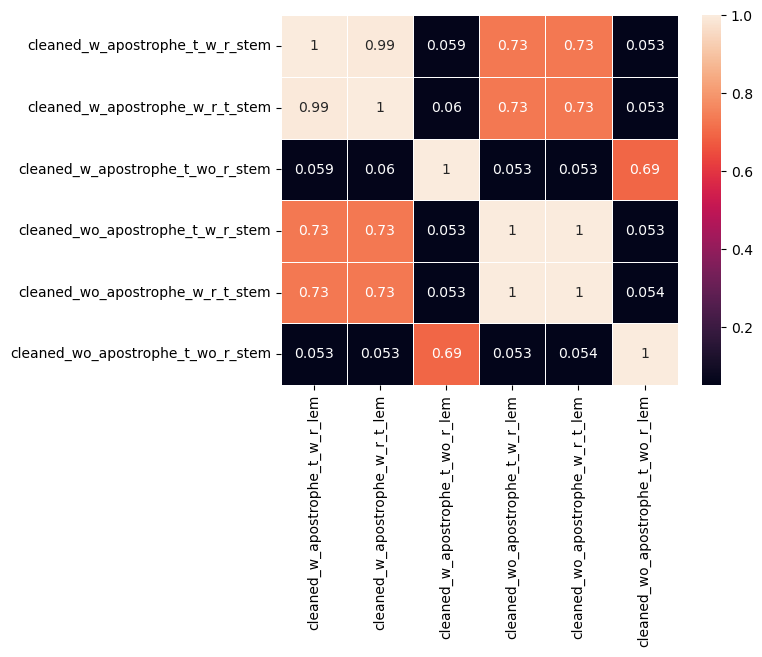

In [39]:
sns.heatmap(
    value_matrix[0], 
    annot=True, 
    linewidths=.5, 
    xticklabels=column_names[0], 
    yticklabels=column_names[1]
    )

<Axes: >

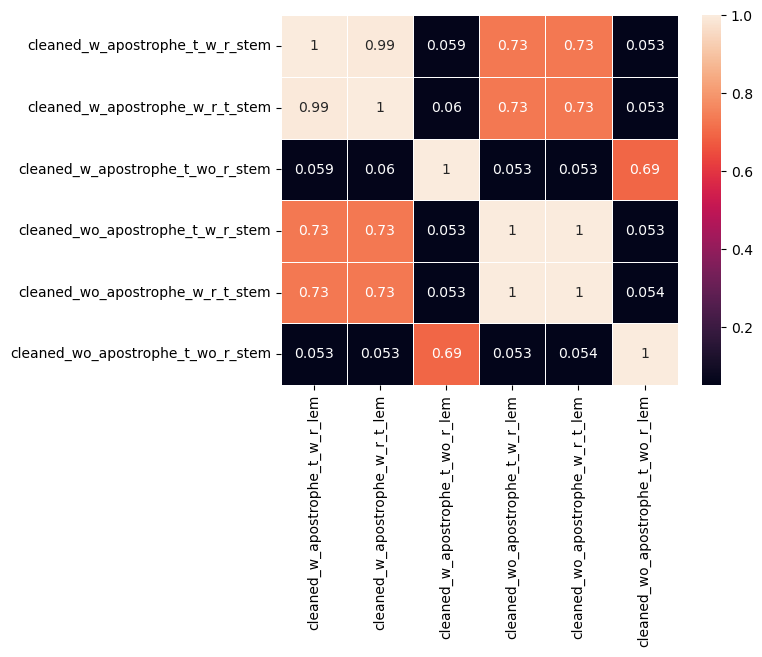

In [40]:
sns.heatmap(
    value_matrix[1], 
    annot=True, linewidths=.5, 
    xticklabels=column_names[0], 
    yticklabels=column_names[1]
    )

##### Ergebnis:
Egal, ob beim Lemmatizing oder beim Stemming, es scheint, dass die Reihenfolge von tokenizing und removing stopwords keinen/keinen großen Unterschied macht.

=> Wir wählen die 9 Datensätze: 
```
[
    'cleaned_w_apostrophe_t_w_r_lem',
    'cleaned_w_apostrophe_t_wo_r_lem',
    'cleaned_wo_apostrophe_t_w_r_lem',
    'cleaned_wo_apostrophe_t_wo_r_lem'
]
```
und
```
[
    'cleaned_w_apostrophe_t_w_r_stem',
    'cleaned_w_apostrophe_t_wo_r_stem',
    'cleaned_wo_apostrophe_t_w_r_stem',
    'cleaned_wo_apostrophe_t_wo_r_stem'
]
```
außerdem zum Vergleich den unveränderten Datensatz:
```
[
    'tweets'
]
```
 

In [41]:
train_df

,sentiment,tweets,cleaned_w_apostrophe,cleaned_w_apostrophe_t,cleaned_w_apostrophe_t_w_r,cleaned_w_apostrophe_t_w_r_lem,cleaned_w_apostrophe_w_r_t,cleaned_w_apostrophe_w_r_t_lem,cleaned_w_apostrophe_t_wo_r,cleaned_w_apostrophe_t_wo_r_lem,...,cleaned_wo_apostrophe_w_r_t,cleaned_wo_apostrophe_w_r_t_lem,cleaned_wo_apostrophe_t_wo_r,cleaned_wo_apostrophe_t_wo_r_lem,cleaned_w_apostrophe_t_w_r_stem,cleaned_w_apostrophe_w_r_t_stem,cleaned_w_apostrophe_t_wo_r_stem,cleaned_wo_apostrophe_t_w_r_stem,cleaned_wo_apostrophe_w_r_t_stem,cleaned_wo_apostrophe_t_wo_r_stem
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",aww that's a bummer you shoulda got david carr of third day to do it d,"[aww, that's, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]","[aww, that's, bummer, shoulda, got, david, carr, third, day]","[aww, that's, bummer, shoulda, got, david, carr, third, day]","[aww, that's, bummer, shoulda, got, david, carr, third, day]","[aww, that's, bummer, shoulda, got, david, carr, third, day]","[aww, that's, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]","[aww, that's, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]",...,"[aww, bummer, shoulda, got, david, carr, third, day]","[aww, bummer, shoulda, got, david, carr, third, day]","[aww, that, s, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]","[aww, that, s, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]","[aww, that', bummer, shoulda, got, david, carr, third, day]","[aww, that', bummer, shoulda, got, david, carr, third, day]","[aww, that', a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]","[aww, bummer, shoulda, got, david, carr, third, day]","[aww, bummer, shoulda, got, david, carr, third, day]","[aww, that, s, a, bummer, you, shoulda, got, david, carr, of, third, day, to, do, it, d]"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he can't update his facebook by texting it and might cry as a result school today also blah,"[is, upset, that, he, can't, update, his, facebook, by, texting, it, and, might, cry, as, a, result, school, today, also, blah]","[upset, can't, update, facebook, texting, might, cry, result, school, today, also, blah]","[upset, can't, update, facebook, texting, might, cry, result, school, today, also, blah]","[upset, can't, update, facebook, texting, might, cry, result, school, today, also, blah]","[upset, can't, update, facebook, texting, might, cry, result, school, today, also, blah]","[is, upset, that, he, can't, update, his, facebook, by, texting, it, and, might, cry, as, a, result, school, today, also, blah]","[is, upset, that, he, can't, update, his, facebook, by, texting, it, and, might, cry, a, a, result, school, today, also, blah]",...,"[upset, update, facebook, texting, might, cry, result, school, today, also, blah]","[upset, update, facebook, texting, might, cry, result, school, today, also, blah]","[is, upset, that, he, can, t, update, his, facebook, by, texting, it, and, might, cry, as, a, result, school, today, also, blah]","[is, upset, that, he, can, t, update, his, facebook, by, texting, it, and, might, cry, a, a, result, school, today, also, blah]","[upset, can't, updat, facebook, text, might, cri, result, school, today, also, blah]","[upset, can't, updat, facebook, text, might, cri, result, school, today, also, blah]","[is, upset, that, he, can't, updat, hi, facebook, by, text, it, and, might, cri, as, a, result, school, today, also, blah]","[upset, updat, facebook, text, might, cri, result, school, today, also, blah]","[upset, updat, facebook, text, might, cri, result, school, today, also, blah]","[is, upset, that, he, can, t, updat, hi, facebook, by, text, it, and, might, cri, as, a, result, school, today, also, blah]"
2,0,@Kenichan I dived m

## Datensätze herstellen

In [75]:
# Load Datasets into Dataframe
train_df = pd.read_csv(
    TRAIN_DATA_NAME,
    encoding=ENCODING,
    header=0,
    names=TRAIN_COLUMN_NAMES,
    nrows=NROWS
    )



test_df = pd.read_csv(
    TEST_DATA_NAME,
    encoding=ENCODING,
    header=0,
    names=TEST_COLUMN_NAMES,
    nrows=NROWS
    )

In [76]:
train_df.head(3)

,sentiment,tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds


In [77]:
dataset_variations = [
    ['cleaned_w_apostrophe_t_w_r_lem', True, True, True, 'lem'],
    ['cleaned_w_apostrophe_t_wo_r_lem', True, True, False, 'lem'],
    ['cleaned_wo_apostrophe_t_w_r_lem', False, True, True, 'lem'],
    ['cleaned_wo_apostrophe_t_wo_r_lem', False, True, False, 'lem'],
    ['cleaned_w_apostrophe_t_w_r_stem', True, True, True, 'stem'],
    ['cleaned_w_apostrophe_t_wo_r_stem', True, True, False, 'stem'],
    ['cleaned_wo_apostrophe_t_w_r_stem', False, True, True, 'stem'],
    ['cleaned_wo_apostrophe_t_wo_r_stem', False, True, False, 'stem']
    ]
# zusätzlich den unveränderten Datensatz mit Spalte tweets

In [78]:
from typing import Literal, get_args

_TYPES = Literal["lem", "stem"]


def preprocessing_datasets(
        tweet: str,
        tokenize: bool = True, 
        rem_stopwords: bool = True, 
        normalization_type: _TYPES = 'lem'):

    options = get_args(_TYPES)
    assert normalization_type in options, f"'{normalization_type}' is not in {options}"

    if tokenize:
        tweet = tokenize_tweets(tweet)

    if rem_stopwords:
        tweet = remove_stopwords(tweet)
    
    if normalization_type == 'lem':
        tweet = lemmatize_tweets(tweet) 
    else:
        tweet = stem_tweets(tweet)

    return tweet

In [79]:
def create_and_save_datasets(df, column, train_or_test, combination_name, apostrophe, tokenize, rem_stopwords, normalization):
    df = df.copy()
    
    filename = 'sentiment140/sentiment140_' + train_or_test + '_' + combination_name + '.csv'
    print('Creating file: ' + filename)

    print('Cleaning: ' + filename)
    df[column] = df[column].apply(lambda tweet: clean_tweets(tweet, apostrophe))

    print('Preprocessing: ' + filename)
    df[column] = df[column].apply(lambda tweet: preprocessing_datasets(tweet, tokenize, rem_stopwords, normalization))

    print('Saving: ' + filename)
    df.to_csv(filename, index=False)


In [80]:
train_df.head(4)

,sentiment,tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire


In [81]:
# Train
for version in dataset_variations:
    create_and_save_datasets(train_df, 'tweets', 'train', version[0], version[1], version[2], version[3], version[4])


# Test
for version in dataset_variations:
    create_and_save_datasets(test_df, 'tweets', 'test', version[0], version[1], version[2], version[3], version[4])

Creating file: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_w_r_lem.csv
Cleaning: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_w_r_lem.csv
Preprocessing: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_w_r_lem.csv
Saving: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_w_r_lem.csv
Creating file: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_wo_r_lem.csv
Cleaning: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_wo_r_lem.csv
Preprocessing: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_wo_r_lem.csv
Saving: sentiment140/sentiment140_train_cleaned_w_apostrophe_t_wo_r_lem.csv
Creating file: sentiment140/sentiment140_train_cleaned_wo_apostrophe_t_w_r_lem.csv
Cleaning: sentiment140/sentiment140_train_cleaned_wo_apostrophe_t_w_r_lem.csv
Preprocessing: sentiment140/sentiment140_train_cleaned_wo_apostrophe_t_w_r_lem.csv
Saving: sentiment140/sentiment140_train_cleaned_wo_apostrophe_t_w_r_lem.csv
Creating file: sentiment140/sentiment140_tra